# Main Imports

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import json # Export dictionary of tuned parameters.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning.
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier, StackingClassifier



# Evaluation metrics import
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
)

from sklearn.metrics import classification_report

# Models import
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Visualisations import
import seaborn as sns
import matplotlib.pyplot as plt

# Global variables

In [2]:
#This is for data, which is most important split.
RANDOM_STATE = 42 

# Task 1.1 Exploration

# Task 1.2 Workflow related functions

# Task 1.2 Hyperparameter tuning workflow related functions

### Workflow related functions for each model hyperparameter tuning

#### Visualization related function

In [3]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    """
    Plots a heatmap for the given confusion matrix with annotations.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

#### Load data

In [4]:
def load_data(file_path):
    """
    Load a dataset from a specified file path. Supports gzip-compressed files.
    """
    return pd.read_csv(file_path, compression='gzip')

#### Split data

In [5]:
def train_split(data, label_col, random_state=42, test_size=0.2):
    """
    Splits the dataset into training and testing sets without preprocessing.
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


#### Create Pipeline

In [6]:
def create_pipeline(model, model_name, standardize=False, with_pca=False, n_pca_components=10):
    """
    Creates a pipeline for a given model with optional standardization and PCA.
    """
    steps = []
    if standardize:
        steps.append(('scaler', StandardScaler()))
    if with_pca:
        steps.append(('pca', PCA(n_components=n_pca_components)))

    if "random_state" in model.get_params():
        model.set_params(random_state=42)

    steps.append((model_name, model))
    pipeline = Pipeline(steps)
    print(f"Pipeline Steps ({model_name}):", pipeline.steps)  # Debug pipeline steps
    return pipeline

#### Hyperparameter tuning for a single model

In [7]:
def grid_search_tuning(model_name, config, X_train, y_train, scoring="f1", cv_folds=5, n_jobs=-1):
    """
    Perform hyperparameter tuning for a model pipeline using GridSearchCV.
    """
    pipeline = create_pipeline(
        model=config["model"],
        model_name=model_name,
        standardize=config["preprocess"].get("standardize", False),
        with_pca=config["preprocess"].get("pca", False),
        n_pca_components=config["preprocess"].get("pca_components", 10)
    )
    pipeline.set_params(**config["fixed_params"])
    
    # Grid Search Configuration
    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["grid_search_params"],
        scoring=scoring,
        # Cross-validation with fixed random state
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=n_jobs,
        verbose=0
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    elapsed_time = (time.time() - start_time) / 60
    
    # Save Best Parameters and Results
    best_params = grid_search.best_params_
    best_params["MODEL_NAME"] = model_name
    best_params["TIME_ELAPSED_MIN"] = elapsed_time

    # Convert non-serializable objects in best_params to strings
    for key, value in best_params.items():
        if not isinstance(value, (str, int, float, list, dict, bool, type(None))):
            best_params[key] = str(value)

    full_results = pd.DataFrame(grid_search.cv_results_)
    full_results.to_csv(f"Tuning_params/{model_name}_all_results.csv", index=False)

    with open(f"Tuning_params/{model_name}_best_params.json", "w") as f:
        json.dump(best_params, f, indent=4)

    print(f"Model {model_name} tuned in {elapsed_time:.2f} minutes")
    return grid_search, best_params


#### Evaluate optimised Model

In [8]:
def evaluate_optimized_model(model_name, model_config, results_dir, X_train, X_test, y_train, y_test, source_model_name=None):
    """
    Evaluates the performance of a single optimized model and saves results.
    """
    try:
        # Use source model name for loading best parameters if provided
        param_source_name = source_model_name or model_name

        # Load Best Parameters
        with open(f"{results_dir}/{param_source_name}_best_params.json", "r") as f:
            best_params = json.load(f)
        
        # Ensure random_state is consistent across all steps
        if "random_state" in model_config["model"].get_params():
            model_config["model"].set_params(random_state=42)
        print("Loaded Best Parameters:", best_params)
        
        pipeline_params = {k: v for k, v in best_params.items() if "__" in k}
        print("Pipeline Parameters to Set:", pipeline_params)

        # Create Pipeline
        pipeline = create_pipeline(
            model=model_config["model"],
            model_name=model_name,
            standardize=model_config["preprocess"].get("standardize", False),
            with_pca=model_config["preprocess"].get("pca", False),
            n_pca_components=model_config["preprocess"].get("pca_components", 10)
        )
        print("Pipeline Before Setting Params:", pipeline.steps)
        pipeline.set_params(**pipeline_params)
        print("Pipeline After Setting Params:", pipeline.steps)

        # Fit Pipeline to Training Data
        pipeline.fit(X_train, y_train)

        # Evaluate on Test Data
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]) if hasattr(pipeline, "predict_proba") else None
        confusion = confusion_matrix(y_test, y_pred)

        results = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Balanced Accuracy": balanced_accuracy,
            "AUC": auc_score,
            "F1 Score": f1,
            "Confusion Matrix": confusion.tolist()
        }

        # Save Results
        pd.DataFrame([results]).to_csv(f"{results_dir}/{model_name}_evaluation_summary.csv", index=False)
        print(f"Evaluation results for {model_name} saved in file {results_dir}/{model_name}_evaluation_summary.csv")
        return results
    except Exception as e:
        print(f"Error evaluating model {model_name}: {e}")
        return {"Model": model_name, "Error": str(e)}


## Tuning and Evaluation stage (All models)

In [9]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

### Tuning LDA no PCA

In [10]:
# LDA Configuration
lda_config = {
    "model": LinearDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"lda__tol": 0.0001},
    "grid_search_params": [
        {"lda__solver": ["svd"]},
        {"lda__solver": ["lsqr"], "lda__shrinkage": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "auto"]}
    ]
}

# Tune LDA and get the best params
lda_results, lda_best_params = grid_search_tuning("lda", lda_config, X_train, y_train)

Pipeline Steps (lda): [('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())]


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model lda tuned in 5.62 minutes


In [11]:
# Print the best parameters used after tuning
print("Best Parameters for LDA without PCA:")
print(lda_best_params)

Best Parameters for LDA without PCA:
{'lda__shrinkage': 0.8, 'lda__solver': 'lsqr', 'MODEL_NAME': 'lda', 'TIME_ELAPSED_MIN': 5.621273163954417}


In [12]:
# Evaluate LDA with best params
print("Evaluation Results for LDA without PCA:")
lda_eval = evaluate_optimized_model("lda", lda_config, "Tuning_params", X_train, X_test, y_train, y_test)
lda_eval

Evaluation Results for LDA without PCA:
Loaded Best Parameters: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr', 'MODEL_NAME': 'lda', 'TIME_ELAPSED_MIN': 5.621273163954417}
Pipeline Parameters to Set: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr'}
Pipeline Steps (lda): [('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())]
Pipeline Before Setting Params: [('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())]
Pipeline After Setting Params: [('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'))]
Evaluation results for lda saved in file Tuning_params/lda_evaluation_summary.csv


{'Model': 'lda',
 'Accuracy': 0.965296803652968,
 'Balanced Accuracy': 0.95587000064612,
 'AUC': 0.9932336872635381,
 'F1 Score': 0.9511568123393316,
 'Confusion Matrix': [[687, 6], [32, 370]]}

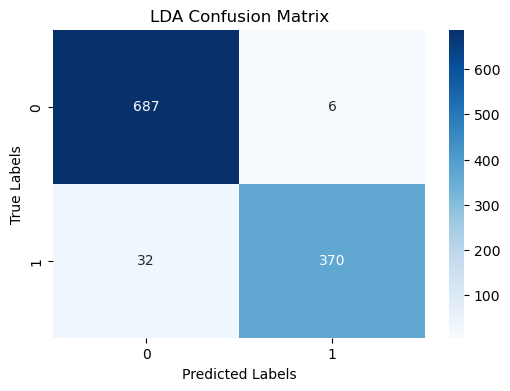

In [13]:
# Print confusion matrix
if "Confusion Matrix" in lda_eval:
    labels = sorted(np.unique(y_test))  # Ensure proper labels are used
    plot_confusion_matrix(lda_eval["Confusion Matrix"], labels, title="LDA Confusion Matrix")

### Using the best tuning params for LDA with PCA 10 components

In [17]:
# Print the best parameters
print("lda_best_params:", lda_best_params)

# Step 1: Transform parameters for the lda_pca step
lda_pca_fixed_params = {
    f"lda_pca__{key.split('__')[1]}": value for key, value in lda_best_params.items() if "__" in key
}
lda_pca_fixed_params["lda_pca__tol"] = 0.0001  # Add additional fixed parameters manually
print("Transformed Params for lda_pca:", lda_pca_fixed_params)

# Step 2: LDA Configuration for PCA
lda_pca_config = {
    "model": LinearDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": True},  # Enable PCA
    "fixed_params": lda_pca_fixed_params
}
print("LDA PCA Config:", lda_pca_config)

# Step 3: Evaluate LDA With PCA
lda_pca_eval = evaluate_optimized_model(
    model_name="lda_pca",
    model_config=lda_pca_config,
    results_dir="Tuning_params",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    source_model_name="lda"  # Reuse parameters from LDA without PCA
)

# Step 4: Print Evaluation Results for LDA With PCA
print("Evaluation Results for LDA with PCA:")
print(lda_pca_eval)

# Step 5: Plot Confusion Matrix for LDA With PCA
if "Confusion Matrix" in lda_pca_eval:
    labels = sorted(np.unique(y_test))
    plot_confusion_matrix(lda_pca_eval["Confusion Matrix"], labels, title="LDA Confusion Matrix (With PCA, 10 Components)")


lda_best_params: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr', 'MODEL_NAME': 'lda', 'TIME_ELAPSED_MIN': 5.621273163954417}
Transformed Params for lda_pca: {'lda_pca__shrinkage': 0.8, 'lda_pca__solver': 'lsqr', 'lda_pca__tol': 0.0001}
LDA PCA Config: {'model': LinearDiscriminantAnalysis(), 'preprocess': {'standardize': True, 'pca': True}, 'fixed_params': {'lda_pca__shrinkage': 0.8, 'lda_pca__solver': 'lsqr', 'lda_pca__tol': 0.0001}}
Loaded Best Parameters: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr', 'MODEL_NAME': 'lda', 'TIME_ELAPSED_MIN': 5.621273163954417}
Pipeline Parameters to Set: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr'}
Pipeline Steps (lda_pca): [('scaler', StandardScaler()), ('pca', PCA(n_components=10)), ('lda_pca', LinearDiscriminantAnalysis())]
Pipeline Before Setting Params: [('scaler', StandardScaler()), ('pca', PCA(n_components=10)), ('lda_pca', LinearDiscriminantAnalysis())]
Error evaluating model lda_pca: Invalid parameter 'lda' for estimator Pipeline(steps=[('s

In [15]:
if "Confusion Matrix" in lda_pca_eval:
    labels = sorted(np.unique(y_test))
    plot_confusion_matrix(lda_pca_eval["Confusion Matrix"], labels, title="LDA (PCA 10 Components) Confusion Matrix")

### Tuning logistic No PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Logistic Regression Configuration
logit_config = {
    "model": LogisticRegression(random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "logit__max_iter": 100,
        "logit__solver": "saga",
        "logit__n_jobs": -1,
        "logit__penalty": "elasticnet"
    },
    "grid_search_params": {
        "logit__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
        "logit__l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "logit__class_weight": [None, "balanced"]
    }
}

# Tune Logistic Regression
logit_results, logit_best_params = grid_search_tuning("logit", logit_config, X_train, y_train)



In [ ]:
# Evaluate Logistic Regression
logit_eval = evaluate_optimized_model("logit", logit_config, "Tuning_params", X_train, X_test, y_train, y_test)
logit_eval

## Model hyperparameter tuning and evaluation workflow

In [2]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    """
    Plots a heatmap for the given confusion matrix with annotations.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()


In [3]:
def load_data(file_path):
    """
    Load a dataset from a specified file path. Supports gzip-compressed files.
    """
    return pd.read_csv(file_path, compression='gzip')


In [4]:
def train_split(data, label_col, random_state=42, test_size=0.2):
    """
    Splits the dataset into training and testing sets without preprocessing.
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [ ]:
class ModelPipeline:
    def __init__(self, model, name, standardize=False, with_pca=False, n_pca_components=10, random_state=42):
        """
        Constructor to initialize the pipeline for a given model.
        - model: The machine learning model (e.g., LDA, RandomForest).
        - name: A unique name for the model.
        - standardize: Whether to apply StandardScaler.
        - with_pca: Whether to include PCA.
        - n_pca_components: Number of PCA components if PCA is used.
        """
        self.model = model
        self.name = name
        self.standardize = standardize
        self.with_pca = with_pca
        self.n_pca_components = n_pca_components
        self.pipeline = None
        self.best_params = {}
        self.results = {}  # Store evaluation results for each model

        # Ensure model uses random_state if supported (fixing randomness)
        if "random_state" in self.model.get_params():
            self.model.set_params(random_state=self.random_state)

    def create_pipeline(self):
        """
        Assembles the pipeline steps dynamically based on the configuration:
        - Adds StandardScaler if standardize=True.
        - Adds PCA if with_pca=True.
        - Adds the given model at the end.
        """
        steps = []
        if self.standardize:
            steps.append(('scaler', StandardScaler()))
        if self.with_pca:
            steps.append(('pca', PCA(n_components=self.n_pca_components)))
        steps.append((self.name, self.model))
        self.pipeline = Pipeline(steps)
        # print(f"Pipeline Created: {self.pipeline}")
        return self.pipeline

    def set_params(self, params):
        """
        Updates the parameters of the pipeline.
        - params: Dictionary of parameters to set.
        """
        if not self.pipeline:
            raise ValueError("Pipeline not created. Call create_pipeline() first.")
        self.pipeline.set_params(**params)

    def tune(self, X_train, y_train, param_grid, scoring="f1", cv_folds=5, n_jobs=-1):
        """
        Performs hyperparameter tuning using GridSearchCV.
        - X_train, y_train: Training data and labels.
        - param_grid: Grid of hyperparameters to tune.
        - scoring: base the scoring on the f1 metric
        - cv_folds: Number of cross-validation folds.
        - n_jobs: Number of parallel jobs for GridSearchCV (-1 means maximum possible)
        """
        # Esnsure pipeline is created
        if not self.pipeline:
            self.create_pipeline() 

        # Setup GridSearchCV with the pipeline
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid=param_grid,
            scoring=scoring,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state),
            n_jobs=n_jobs,
            verbose=0
        )


        start_time = time.time() # Track tuning time
        grid_search.fit(X_train, y_train) # Fit the grid search
        elapsed_time = (time.time() - start_time) / 60 # Time in minutes

        # Store the best parameters and save results
        self.best_params = grid_search.best_params_
        self.best_params["MODEL_NAME"] = self.name
        self.best_params["TIME_ELAPSED_MIN"] = elapsed_time

        # Save all results and best parameters
        full_results = pd.DataFrame(grid_search.cv_results_)
        full_results.to_csv(f"Tuning_params/{self.name}_all_results.csv", index=False)
        with open(f"Tuning_params/{self.name}_best_params.json", "w") as f:
            json.dump(self.best_params, f, indent=4)

        print(f"Model {self.name} tuned in {elapsed_time:.2f} minutes") #log running time

    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        Evaluates the performance of the pipeline on test data.
        - X_train, X_test: Training and testing feature matrices.
        - y_train, y_test: Training and testing labels.
        """
        if not self.pipeline:
            self.create_pipeline()

        if self.best_params:
            # Filter only valid pipeline parameters
            valid_params = {
                key: value for key, value in self.best_params.items()
                if key in self.pipeline.get_params()
            }
            print(f"Valid Parameters for Pipeline: {valid_params}")
            self.pipeline.set_params(**valid_params) # Set valid parameters

        # Train the pipeline on training data
        self.pipeline.fit(X_train, y_train)
        # Predict on test data
        y_pred = self.pipeline.predict(X_test)

        # Compute evaluation metrics
        metrics = {
            "Model": self.name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
        }

        # Calculate AUC if available
        if hasattr(self.pipeline, "predict_proba"):
            metrics["AUC"] = roc_auc_score(y_test, self.pipeline.predict_proba(X_test)[:, 1])
        else:
            metrics["AUC"] = None

        # Add confusion matrix (fir plot)
        metrics["Confusion Matrix"] = confusion_matrix(y_test, y_pred).tolist()
        print(f"Evaluation Results: {metrics}")

        # # Save evaluation metrics
        self.results = metrics
        pd.DataFrame([metrics]).to_csv(f"Tuning_params/{self.name}_evaluation_summary.csv", index=False)



In [ ]:
def aggregate_results(models):
    """
    Aggregates results from multiple ModelPipeline instances into a single DataFrame (To merge all models' results)
    """
    all_results = [model.results for model in models]
    results_df = pd.DataFrame(all_results)
    results_df.to_csv("Model_Comparison_Results.csv", index=False)
    print("Aggregated results saved to Model_Comparison_Results.csv")
    return results_df


### Loading data

In [7]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Train-Test Split
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)


### LDA Without PCA

In [ ]:
lda_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda",
    standardize=True,
    with_pca=False
)
lda_model.create_pipeline()
lda_grid = [
    {"lda__solver": ["svd"]},
    {"lda__solver": ["lsqr"], "lda__shrinkage": [0.0, 0.1, 0.5, 1.0, "auto"]}
]
lda_model.tune(X_train, y_train, lda_grid)
print(f"Best parameters found for {lda_model.name}")
print(lda_model.best_params)
lda_model.evaluate(X_train, X_test, y_train, y_test)
print(f"results of evaluating {lda_model.name}")
print(lda_model.results)

In [ ]:
confusion = lda_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_model.name}")

### LDA with PCA (10 components)

In [ ]:
lda_pca_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10
)
lda_pca_model.create_pipeline()
lda_pca_model.set_params({
    f"lda_pca__{key.split('__')[1]}": value for key, value in lda_model.best_params.items() if "__" in key
})
lda_pca_model.evaluate(X_train, X_test, y_train, y_test)


In [ ]:
confusion = lda_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_pca_model.name}")

In [ ]:
# Aggregate and Save Results
results_df = aggregate_results(models)

results_df

### Tuning Logistic with PCA 10 components

### Tuning QDA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# QDA Configuration
qda_config = {
    "model": QuadraticDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"qda__priors": None},
    "grid_search_params": {
        "qda__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
}

# Tune QDA
qda_results = grid_search_tuning("qda", qda_config, X_train, y_train)

# Evaluate QDA
qda_eval = evaluate_optimized_model("qda", qda_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(qda_eval)


### Tuning K-nn

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# KNN Configuration
knn_config = {
    "model": KNeighborsClassifier(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "knn__metric": "minkowski",
        "knn__n_jobs": 1
    },
    "grid_search_params": {
        "knn__p": [0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.2, 3.0, 10.0],
        "knn__weights": ["uniform", "distance"],
        "knn__n_neighbors": [1, 3, 5, 9, 11, 15, 20, 30]
    }
}

# Tune KNN
knn_results = grid_search_tuning("knn", knn_config, X_train, y_train)

# Evaluate KNN
knn_eval = evaluate_optimized_model("knn", knn_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(knn_eval)


### Tuning SVM

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# SVM Configuration
svm_config = {
    "model": SVC(probability=True, random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"svm__degree": 3},
    "grid_search_params": {
        "svm__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "svm__gamma": ["scale", "auto"],
        "svm__class_weight": [None, "balanced"]
    }
}

# Tune SVM
svm_results = grid_search_tuning("svm", svm_config, X_train, y_train)

# Evaluate SVM
svm_eval = evaluate_optimized_model("svm", svm_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(svm_eval)


### Tuning Random forest

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Random Forest Configuration
rf_config = {
    "model": RandomForestClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": False},
    "fixed_params": {"rf__bootstrap": True},
    "grid_search_params": {
        "rf__n_estimators": [100, 200, 300, 400],
        "rf__criterion": ["gini", "entropy"],
        "rf__max_features": ["sqrt", "log2"]
    }
}

# Tune Random Forest
rf_results = grid_search_tuning("rf", rf_config, X_train, y_train)

# Evaluate Random Forest
rf_eval = evaluate_optimized_model("rf", rf_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(rf_eval)


### Tuning Gradient Boosting

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Gradient Boosting Configuration
gbdt_config = {
    "model": GradientBoostingClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": False},
    "fixed_params": {
        "gbdt__loss": "log_loss",
        "gbdt__n_iter_no_change": 15
    },
    "grid_search_params": {
        "gbdt__n_estimators": [100, 200, 300, 400, 500],
        "gbdt__max_depth": [1, 3, 5, 7, 9],
        "gbdt__learning_rate": [0.1, 0.05, 0.2, 0.3],
        "gbdt__max_features": ["sqrt", 100, 130]
    }
}

# Tune Gradient Boosting
gbdt_results = grid_search_tuning("gbdt", gbdt_config, X_train, y_train)

# Evaluate Gradient Boosting
gbdt_eval = evaluate_optimized_model("gbdt", gbdt_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(gbdt_eval)


#### Combine evaluation results for all models without PCA (after completion)

In [ ]:
# Combine all evaluation results into a single DataFrame
final_results = pd.DataFrame([
    lda_eval, 
    logit_eval, 
    qda_eval, 
    knn_eval, 
    svm_eval, 
    rf_eval, 
    gbdt_eval
])

# Save the combined results to a CSV
final_results.to_csv("no_pca_results.csv", index=False)

# Display the final results
final_results

## Tuning stage with PCA

### LDA with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# LDA Configuration with PCA
lda_pca_config = {
    "model": LinearDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": True},  # Enable PCA
    "fixed_params": {"lda_pca__tol": 0.0001},
    "grid_search_params": [
        {"lda_pca__solver": ["svd"], "pca__n_components": [5, 10, 20]},
        {"lda_pca__solver": ["lsqr"], "lda_pca__shrinkage": [0.0, 0.1, 0.5, "auto"], "pca__n_components": [5, 10, 20]}
    ]
}

# Tune LDA with PCA
lda_pca_results = grid_search_tuning("lda_pca", lda_pca_config, X_train, y_train)

# Evaluate LDA with PCA
lda_pca_eval = evaluate_optimized_model("lda_pca", lda_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

lda_pca_eval


### Logistic Regression with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Logistic Regression Configuration with PCA
logit_pca_config = {
    "model": LogisticRegression(random_state=42),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {
        "logit_pca__max_iter": 100,
        "logit_pca__solver": "saga",
        "logit_pca__n_jobs": -1,
        "logit_pca__penalty": "elasticnet"
    },
    "grid_search_params": {
        "logit_pca__C": [0.01, 0.1, 1, 10],
        "logit_pca__l1_ratio": [0.1, 0.5, 0.9],
        "logit_pca__class_weight": [None, "balanced"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Logistic Regression with PCA
logit_pca_results = grid_search_tuning("logit_pca", logit_pca_config, X_train, y_train)

# Evaluate Logistic Regression with PCA
logit_pca_eval = evaluate_optimized_model("logit_pca", logit_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

logit_pca_eval


### QDA with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# QDA Configuration with PCA
qda_pca_config = {
    "model": QuadraticDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {"qda_pca__priors": None},
    "grid_search_params": {
        "qda_pca__reg_param": [0.0, 0.1, 0.5, 1.0],
        "pca__n_components": [5, 10, 20]
    }
}


# Tune QDA with PCA
qda_pca_results = grid_search_tuning("qda_pca", qda_pca_config, X_train, y_train)

# Evaluate QDA with PCA
qda_pca_eval = evaluate_optimized_model("qda_pca", qda_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

qda_pca_eval


### K-nn with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# KNN Configuration with PCA
knn_pca_config = {
    "model": KNeighborsClassifier(),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {
        "knn_pca__metric": "minkowski",
        "knn_pca__n_jobs": 1
    },
    "grid_search_params": {
        "knn_pca__p": [1, 2],  # Manhattan and Euclidean distances
        "knn_pca__weights": ["uniform", "distance"],
        "knn_pca__n_neighbors": [3, 5, 10],  # Common choices for neighbors
        "pca__n_components": [5, 10, 20]  # Reduced dimensions
    }
}

# Tune KNN with PCA
knn_pca_results = grid_search_tuning("knn_pca", knn_pca_config, X_train, y_train)

# Evaluate KNN with PCA
knn_pca_eval = evaluate_optimized_model("knn_pca", knn_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

knn_pca_eval


### SVM with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# SVM Configuration with PCA
svm_pca_config = {
    "model": SVC(probability=True, random_state=42),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {"svm_pca__degree": 3},  # Use 'svm_pca__' to match pipeline step name
    "grid_search_params": {
        "svm_pca__C": [0.1, 1, 10],
        "svm_pca__kernel": ["linear", "rbf"],
        "svm_pca__gamma": ["scale", "auto"],
        "svm_pca__class_weight": [None, "balanced"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune SVM with PCA
svm_pca_results = grid_search_tuning("svm_pca", svm_pca_config, X_train, y_train)

# Evaluate SVM with PCA
svm_pca_eval = evaluate_optimized_model("svm_pca", svm_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

svm_pca_eval


### RF with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Random Forest Configuration with PCA
rf_pca_config = {
    "model": RandomForestClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": True},
    "fixed_params": {"rf_pca__bootstrap": True},  # Correct parameter prefix
    "grid_search_params": {
        "rf_pca__n_estimators": [100, 200, 300],
        "rf_pca__criterion": ["gini", "entropy"],
        "rf_pca__max_features": ["sqrt", "log2"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Random Forest with PCA
rf_pca_results = grid_search_tuning("rf_pca", rf_pca_config, X_train, y_train)

# Evaluate Random Forest with PCA
rf_pca_eval = evaluate_optimized_model("rf_pca", rf_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(rf_pca_eval)


### GBDT with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Gradient Boosting Configuration with PCA
gbdt_pca_config = {
    "model": GradientBoostingClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": True},
    "fixed_params": {"gbdt_pca__loss": "log_loss", "gbdt_pca__n_iter_no_change": 15},  # Correct parameter prefix
    "grid_search_params": {
        "gbdt_pca__n_estimators": [100, 200],
        "gbdt_pca__max_depth": [3, 5],
        "gbdt_pca__learning_rate": [0.05, 0.1, 0.2],
        "gbdt_pca__max_features": ["sqrt", 100],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Gradient Boosting with PCA
gbdt_pca_results = grid_search_tuning("gbdt_pca", gbdt_pca_config, X_train, y_train)

# Evaluate Gradient Boosting with PCA
gbdt_pca_eval = evaluate_optimized_model("gbdt_pca", gbdt_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(gbdt_pca_eval)


In [ ]:
# Combine PCA evaluation results into a single DataFrame
pca_results = pd.DataFrame([
    lda_pca_eval, 
    logit_pca_eval, 
    qda_pca_eval, 
    knn_pca_eval, 
    svm_pca_eval, 
    rf_pca_eval, 
    gbdt_pca_eval
])

# Save the PCA-only results to a CSV
pca_results.to_csv("pca_results.csv", index=False)

# Display the PCA-only results
print(pca_results)

## Combining full results

In [ ]:
# Combine all evaluation results (standard + PCA) into a single DataFrame
final_results = pd.DataFrame([
    lda_eval, 
    lda_pca_eval, 
    logit_eval, 
    logit_pca_eval, 
    qda_eval, 
    qda_pca_eval, 
    knn_eval, 
    knn_pca_eval, 
    svm_eval, 
    svm_pca_eval, 
    rf_eval, 
    rf_pca_eval, 
    gbdt_eval, 
    gbdt_pca_eval
])

# Save the full results to a CSV
final_results.to_csv("final_results.csv", index=False)

# Display the full results
final_results

# Task 1.3

### Adaboost Without PCA

In [ ]:
# AdaBoost Configuration without PCA
ada_boost_no_pca_config = {
    "model": AdaBoostClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "ada_boost_no_pca__algorithm": "SAMME"  # Correct prefix for pipeline step
    },
    "grid_search_params": {
        "ada_boost_no_pca__estimator": [DecisionTreeClassifier(max_depth=2), LogisticRegression()],  # Use 'estimator' instead of 'base_estimator'
        "ada_boost_no_pca__n_estimators": [50, 100, 200],
        "ada_boost_no_pca__learning_rate": [0.05, 0.1, 0.5, 1]
    }
}

# Tune AdaBoost without PCA
ada_boost_no_pca_results, ada_boost_no_pca_best_params = grid_search_tuning("ada_boost_no_pca", ada_boost_no_pca_config, X_train, y_train)

# Evaluate AdaBoost without PCA
ada_boost_no_pca_eval = evaluate_optimized_model("ada_boost_no_pca", ada_boost_no_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
print(ada_boost_no_pca_eval)


### Adaboost With PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# AdaBoost Configuration with PCA
ada_boost_pca_config = {
    "model": AdaBoostClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": True},  # Enable PCA
    "fixed_params": {
        "model__algorithm": "SAMME"  # Correct prefix for pipeline step
    },
    "grid_search_params": {
        "model__estimator": [DecisionTreeClassifier(max_depth=2, random_state=42), LogisticRegression(random_state=42)],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.05, 0.1, 0.5, 1],
        "pca__n_components": [5, 10, 20]  # PCA dimensionality reduction
    }
}

# Tune AdaBoost with PCA
ada_boost_pca_results, ada_boost_pca_best_params = grid_search_tuning("ada_boost_pca", ada_boost_pca_config, X_train, y_train)

# Evaluate AdaBoost with PCA
ada_boost_pca_eval = evaluate_optimized_model("ada_boost_pca", ada_boost_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
print(ada_boost_pca_eval)


### Voting classifier without PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Voting Classifier without PCA
voting_no_pca_config = {
    "model": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('rf', RandomForestClassifier(random_state=42))
        ]
    ),
    "preprocess": {"standardize": True, "pca": False},  # PCA disabled
    "fixed_params": {},  # No fixed parameters specific to voting
    "grid_search_params": {
        "voting_no_pca__voting": ["hard", "soft"]  # Prefix with the pipeline step name
    }
}

# Tune Voting Classifier without PCA
voting_no_pca_results = grid_search_tuning("voting_no_pca", voting_no_pca_config, X_train, y_train)

# Evaluate Voting Classifier without PCA
voting_no_pca_eval = evaluate_optimized_model("voting_no_pca", voting_no_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Results
print(voting_no_pca_eval)


### Voting classifier with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Voting Classifier with PCA
voting_pca_config = {
    "model": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('rf', RandomForestClassifier(random_state=42))
        ]
    ),
    "preprocess": {"standardize": True, "pca": True},  # PCA enabled
    "fixed_params": {},  # No fixed parameters specific to voting
    "grid_search_params": {
        "voting_pca__voting": ["hard", "soft"],  # Prefix to match pipeline step
        "pca__n_components": [5, 10, 20]  # Parameter for PCA
    }
}

# Tune Voting Classifier with PCA
voting_pca_results = grid_search_tuning("voting_pca", voting_pca_config, X_train, y_train)

# Evaluate Voting Classifier with PCA
voting_pca_eval = evaluate_optimized_model("voting_pca", voting_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
print(voting_pca_eval)

### Bagging classifiers without PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Bagging Classifier Configuration
bagging_config = {
    "model": BaggingClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": False},  # PCA disabled
    "fixed_params": {"bagging__n_jobs": -1},  # Use all processors
    "grid_search_params": {
        "bagging__n_estimators": [10, 50, 100],
        "bagging__estimator": [DecisionTreeClassifier(max_depth=5), LogisticRegression()]
    }
}

# Tune Bagging Classifier
bagging_results = grid_search_tuning("bagging", bagging_config, X_train, y_train)

# Evaluate Bagging Classifier
bagging_eval = evaluate_optimized_model("bagging", bagging_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
print(bagging_eval)


### ElasticNet Logistic Regression with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# ElasticNet Logistic Regression with PCA Configuration
elasticnet_pca_config = {
    "model": LogisticRegression(penalty="elasticnet", solver="saga", random_state=42),
    "preprocess": {"standardize": True, "pca": True},  # PCA enabled
    "fixed_params": {"elasticnet_logit_pca__max_iter": 500},  # Correct prefix for pipeline step
    "grid_search_params": {
        "elasticnet_logit_pca__C": [0.01, 0.1, 1, 10],  # Correct prefix for pipeline step
        "elasticnet_logit_pca__l1_ratio": [0.1, 0.5, 0.9],  # Correct prefix for pipeline step
        "pca__n_components": [10, 25, 50]
    }
}

# Tune ElasticNet Logistic Regression with PCA
elasticnet_pca_results = grid_search_tuning("elasticnet_logit_pca", elasticnet_pca_config, X_train, y_train)

# Evaluate ElasticNet Logistic Regression with PCA
elasticnet_pca_eval = evaluate_optimized_model("elasticnet_logit_pca", elasticnet_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)


elasticnet_pca_eval

In [ ]:
# Print Evaluation Results


### StackingClassifier with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Iterate over final estimators for stacking
final_estimators = [
    LogisticRegression(max_iter=500, random_state=42),
    GradientBoostingClassifier(random_state=42)
]

stacking_results = []

for estimator in final_estimators:
    # Stacking Classifier with PCA Configuration
    stacking_pca_config = {
        "model": StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('svc', SVC(probability=True, random_state=42))
            ],
            final_estimator=estimator
        ),
        "preprocess": {"standardize": True, "pca": True},  # PCA enabled
        "fixed_params": {},  # No fixed parameters specific to stacking
        "grid_search_params": {
            "pca__n_components": [10, 25, 50]
        }
    }

    # Tune Stacking Classifier with PCA
    stacking_pca_results = grid_search_tuning(f"stacking_pca_{estimator.__class__.__name__.lower()}", stacking_pca_config, X_train, y_train)

    # Evaluate Stacking Classifier with PCA
    stacking_pca_eval = evaluate_optimized_model(f"stacking_pca_{estimator.__class__.__name__.lower()}", stacking_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

    # Append results
    stacking_results.append(stacking_pca_eval)

# Print Evaluation Results
for result in stacking_results:
    print(result)

## Picking the best model

In [ ]:
# Combine all evaluation results into a single DataFrame
final_results = pd.DataFrame([
    ada_boost_no_pca_eval,
    ada_boost_pca_eval,     
    voting_no_pca_eval,      
    voting_pca_eval,         
    bagging_eval,             
    elasticnet_pca_eval,     
    stacking_pca_eval         
])

# Save the combined results to a CSV
final_results.to_csv("final_results_all_models.csv", index=False)

# Display the final results
final_results

## mypredict()